In [1]:
import sys
sys.path.append("..")
import mklaren
import datasets


import matplotlib.pyplot as plt
% matplotlib inline

import numpy as np
np.set_printoptions(precision=3)

The input data is represented by a set pairs: 
$$ \{(\mathbf{x}_1, y_1), (\mathbf{x}_2, y_2), ..., (\mathbf{x}_n, y_n)\}$$ 

where $\mathbf{x}_i$ represent independent variables (covariates) and $y_i$ are real-valued regression targets. The data is split in 50% (training set) and 50% (test set) in this example.

In [2]:
from datasets.delve import load_boston
data = load_boston()
X = data["data"]
y = data["target"]
print X.shape

tr = range(0, len(X), 2)
te = range(1, len(X), 2)
X_tr, X_te = X[tr], X[te]
y_tr, y_te = y[tr], y[te]

(506, 13)


### The Kernel interface

The central data structure in the library is the ```Kinterface``` (Kernel interface) class. It mimics a Numpy array storing a kernel matrix generated by the ```kernel``` function (with parameters ```kernel_args```) on a finite ```data``` sample. The main reason behind  ```Kinterface``` is the dynamic calculation of the kernel matrix values, as the usual kernel matrix approximation algorithms do not require access to the full kernel matrix.

In [3]:
from mklaren.kernel.kinterface import Kinterface
from mklaren.kernel.kernel import rbf_kernel

K = Kinterface(data=X_tr, kernel=rbf_kernel, kernel_args={"sigma": 30})
K.shape

(253, 253)

The ```Kinterface``` is accessed in a same way as a standard Numpy array, via the addressing brackets. The brackets notation always assumes two arguments and addresses parts of the kernel matrix.  

In [4]:
print "The value of K at row 42 and column 66: "
print K[42, 66]
print 
print "A 3x3 submatrix of K"
print K[:3, :3]

print "Another 3x3 submatrix"
print K[[0, 10, 20], [1, 2, 5]]
print 

print "The value of K of sample 0 against samples 0, 1, 2 ..., 9: "
print K[0, :10]
print

The value of K at row 42 and column 66: 
[  3.821e-10]

A 3x3 submatrix of K
[[ 1.     0.159  0.037]
 [ 0.159  1.     0.761]
 [ 0.037  0.761  1.   ]]
Another 3x3 submatrix
[[  1.594e-01   3.686e-02   4.562e-01]
 [  3.250e-02   4.173e-03   7.641e-01]
 [  1.307e-02   1.166e-02   4.333e-04]]

The value of K of sample 0 against samples 0, 1, 2 ..., 9: 
[  1.000e+00   1.594e-01   3.686e-02   8.170e-01   2.871e-01   4.562e-01
   5.287e-01   5.116e-01   3.452e-01   7.181e-04]



Similarly, the full kernel matrix can be generated.

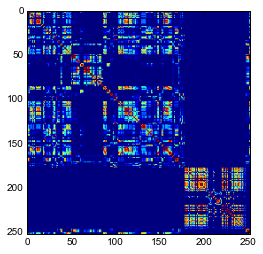

In [5]:
plt.figure()
plt.imshow(K[:, :])
plt.show()

### Low-rank approximations to the kernel matrix

The low rank approximations to ```K``` find a low rank matrix (termed $\mathbf{G}$) such that
$$ \mathbf{K} = \mathbf{G}\mathbf{G}^T $$.

<br/>
<b>Incomplete Cholesky decomposition</b> finds $\mathbf{G}$ by greedily maximizing a lower-bound to the gain in approximation error (Fine, 2002).

In [6]:
from mklaren.projection.icd import ICD

model = ICD(rank=15)
model.fit(K)
G_icd = model.G
inxs = model.active_set_
print "G shape:", G_icd.shape, "Error:", np.linalg.norm(K[:, :]-G_icd.dot(G_icd.T))

G shape: (253, 15) Error: 31.6465811292



<br/>
<br/>
<b>The Nystrom approximation</b> (Seeger, 2001) randomly selects a subset of active colums $\mathcal{A}$ and approximates
$$ \mathbf{\hat{K}} = \mathbf{K}(:, \mathcal{A}) \mathbf{K}^{-1}(\mathcal{A}, \mathcal{A}) \mathbf{K}(:, \mathcal{A})^T   $$ 
or in terms of $\mathbf{G}$:
$$ \mathbf{G} = \mathbf{K}(:, \mathcal{A}) \mathbf{K}^{-1/2}(\mathcal{A}, \mathcal{A}) $$ 


In [7]:
from mklaren.projection.nystrom import Nystrom

model = Nystrom(rank=15)
model.fit(K)
G_nyst = model.G
print "G shape:", G_nyst.shape, "Error:", np.linalg.norm(K[:, :]-G_nyst.dot(G_nyst.T))

G shape: (253, 15) Error: 26.9494542782


The approximations can be compared also visually.

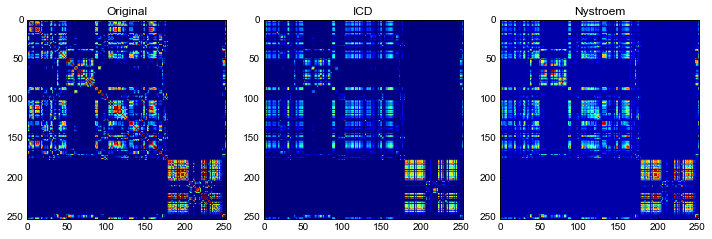

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 6))
ax[0].imshow(K[:, :])
ax[0].set_title("Original")
ax[1].imshow(G_icd.dot(G_icd.T))
ax[1].set_title("ICD")
ax[2].imshow(G_nyst.dot(G_nyst.T))
ax[2].set_title("Nystroem")
fig.tight_layout()
plt.show()

### Low-rank Kernel Regression

In [9]:
from mklaren.regression.ridge import RidgeLowRank

for method in "nystrom", "icd":
    model = RidgeLowRank(method=method, rank=15)
    model.fit([K], y_tr)
    yp = model.predict([X_te])
    rmse = np.var(y_te-yp)**0.5
    print "Method:", method, "Test RMSE:", rmse

Method: nystrom Test RMSE: 7.73586494552
Method: icd Test RMSE: 7.76902846627


### Multiple Kernel Learning

#### Uniform kernel combination

Multiple kernels can be passed to ```RidgeLowRank``` model. This corresponds to an uniform combination of kernels in low-rank feature spaces.

In [10]:
from mklaren.kernel.kernel import linear_kernel, poly_kernel
K_exp  = Kinterface(data=X_tr, kernel=rbf_kernel,  kernel_args={"sigma": 30})  # RBF kernel 
K_poly = Kinterface(data=X_tr, kernel=poly_kernel, kernel_args={"p": 3})      # polynomial kernel with degree=3
K_lin  = Kinterface(data=X_tr, kernel=linear_kernel)                          # linear kernel

model = RidgeLowRank(method="nystrom", rank=5, lbd=1)
model.fit([K_exp, K_lin, K_poly], y_tr)
yp = model.predict([X_te, X_te, X_te])                     # The features passed to each kernel
rmse = np.var(y_tr-yp)**0.5
print "Test RMSE:", rmse

Test RMSE: 8.24654690751



#### Linear combination of kernels

Alternatively, multiple kernel learning methods can be used to learn an optimal combination of kernels. The ```mklaren``` library implements methods based on centered kernel alignment (Cortes et. al, 2012). The following methods operate on <i>full kernel matrices</i>.

Given $p$ kernel matrices $\mathbf{K}_1, \mathbf{K}_2, ..., \mathbf{K}_p$, centered kernel alignment learns a linear combination of kernels resulting in a combined kernel matrix.

$$ \mathbf{K}_{c\mu} = \sum_{q=1}^p \mu_q \mathbf{K}_{cq} $$

where $\mathbf{K}_{cq}$ is the centered kernel matrix:
$$\mathbf{K}_{cq} = (\mathbf{I} - \frac{\mathbf{11}^1}{n})\mathbf{K}_q (\mathbf{I} - \frac{\mathbf{11}^1}{n})$$

The following methods perform a constrained optimization over $\mathbf{\mu} = (\mu_1, \mu_2, ... \mu_p)$ maximizing the <i>centered alignment</i>:

$$ A = \frac{<\mathbf{K}_{c\mu}, \mathbf{y}\mathbf{y}^T>_F} {n <\mathbf{K}_{c\mu}, \mathbf{K}_{c\mu}>_F}  $$

where $\mathbf{y}\mathbf{y}^T$ is the <i>ideal kernel</i> based on target vector $\mathbf{y}$ and $<., .>_F$ is a matrix inner product (the <a href="https://en.wikipedia.org/wiki/Matrix_multiplication#Frobenius_product">Frobenius product</a>).


<b>align</b>. The ```align``` method sets each $\mu_q$ independently such that
$$ \mu_q = <\mathbf{K}_{c\mu}, \mathbf{y}\mathbf{y}^T>_F^d $$
with a user-defined parameter $d$.

In [11]:
from mklaren.mkl.align import Align
model = Align()
model.fit([K_exp, K_lin, K_poly], y_tr)
model.mu  # kernel weights

array([  4.503e-18,   2.022e-12,   1.000e+00])

<b>alignf</b>. The ```alignf``` method optimizes with respect to $\mathbf{\mu}$ to maximize centered alignment.
$$ \text{max}_{\mathbf{\mu}} \frac{<\mathbf{K}_{c\mu}, \mathbf{y}\mathbf{y}^T>_F} {n <\mathbf{K}_{c\mu}, \mathbf{K}_{c\mu}>_F}   $$

such that (```typ=linear```):
$$ \sum \mu_q = 1$$

or contraining sum of wieghts to a convex combination (```typ=convex```):
$$ \sum \mu_q = 1 \text{ and } \mu_q > 0, \forall q$$

In [12]:
from mklaren.mkl.alignf import Alignf
model = Alignf(typ="linear")
model.fit([K_exp, K_lin, K_poly], y_tr)
model.mu  # kernel weights

array([  1.000e+00,   1.221e-04,  -7.850e-17])

In [13]:
model = Alignf(typ="convex")
model.fit([K_exp, K_lin, K_poly], y_tr)
model.mu  # kernel weights (convex combination)

array([  9.999e-01,   1.221e-04,  -7.849e-17])

#### Regression with MKL

The ```RidgeMKL``` model enables regression with multiple kernels and selected alignment method. 


In [18]:
from mklaren.regression.ridge import RidgeMKL
K_exp  = Kinterface(data=X, kernel=rbf_kernel,  kernel_args={"sigma": 30})  # RBF kernel 
K_poly = Kinterface(data=X, kernel=poly_kernel, kernel_args={"p": 3})      # polynomial kernel with degree=3
K_lin  = Kinterface(data=X, kernel=linear_kernel)  
model = RidgeMKL(lbd=1, method="alignf", method_init_args={"typ": "convex"})
model.fit([K_exp, K_lin, K_poly], y, holdout=te)
yp = model.predict(te)
print "RMSE: ", np.var(y_te-yp)**0.5

RMSE:  7.25333046571


<br/>
### Simultaneous Multiple Kernel regression and low-rank approximation

The Mklaren algorithm (Multiple kernel learning with least-angle regression) perform simultaneous low-rank approximation of multiple kernel learning using least-angle regression (Stražar & Curk, 2016).

In [17]:
from mklaren.mkl.mklaren import Mklaren

K_exp  = Kinterface(data=X_tr, kernel=rbf_kernel,  kernel_args={"sigma": 30})  # RBF kernel 
K_poly = Kinterface(data=X_tr, kernel=poly_kernel, kernel_args={"p": 3})      # polynomial kernel with degree=3
K_lin  = Kinterface(data=X_tr, kernel=linear_kernel)  
model = Mklaren(rank=15, lbd=1, delta=30)
model.fit([K_exp, K_lin, K_poly], y_tr)
yp = model.predict([X_te, X_te, X_te])
print "Test RMSE:", np.var(y_te-yp)**0.5

Test RMSE: 6.85100919279


Kernel more related to targets are approximated better.

In [ ]:
G_exp = model.data[0]["G"]
G_lin = model.data[1]["G"]
G_poly = model.data[2]["G"]

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
for i, (name, K, G) in enumerate(zip(["exp", "lin", "poly"], 
                               [K_exp, K_lin, K_poly], 
                               [G_exp, G_lin, G_poly])):
    ax[0, i].set_title(name)
    ax[0, i].imshow(K[:, :])
    ax[1, i].imshow(G.dot(G.T))

ax[0, 0].set_ylabel("Original")
ax[1, 0].set_ylabel("Mklaren")
fig.tight_layout()
plt.show()

### References